In [1]:
# from sb3_contrib import RecurrentPPO
# from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# env = AsvGliderBearingEnv()

# model = RecurrentPPO(
#     "MlpLstmPolicy",
#     env,
#     verbose=1,
#     learning_rate=3e-4,
#     gamma=0.99,
#     batch_size=256,
#     n_steps=512,       # rollout length per update
#     device="cuda",
# )

# model.learn(total_timesteps=1_000_000)
# model.save("recurrent_ppo_asv_bearing_dist_1m_new")
# env.close()


In [2]:
# from stable_baselines3 import TD3
# from stable_baselines3.td3 import MlpPolicy
# from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# env = AsvGliderBearingEnv()

# model = TD3(
#     MlpPolicy,
#     env,
#     verbose=1,
#     learning_rate=3e-4,
#     gamma=0.99,
#     buffer_size=1_000_000,      # replay buffer
#     learning_starts=10_000,     # how long to collect transitions before training
#     batch_size=256,
#     tau=0.005,                  # soft update coefficient
#     train_freq=(1, "episode"),  # or (1, "step")
#     gradient_steps=100,         # updates per training step
#     device="cuda",
# )

# model.learn(total_timesteps=100_000)
# model.save("td3_asv_bearing_dist_1m_new")

# env.close()


In [ ]:
# from stable_baselines3 import DDPG
# from stable_baselines3.ddpg import MlpPolicy
# from stable_baselines3.common.noise import NormalActionNoise
# from asv_glider_bearing_dist_env import AsvGliderBearingEnv
# import numpy as np

# env = AsvGliderBearingEnv()

# # Assuming a continuous action space (Box)
# n_actions = env.action_space.shape[0]

# # Gaussian exploration noise (you can tune sigma)
# action_noise = NormalActionNoise(
#     mean=np.zeros(n_actions),
#     sigma=0.1 * np.ones(n_actions),
# )

# model = DDPG(
#     MlpPolicy,
#     env,
#     verbose=1,
#     learning_rate=3e-4,
#     gamma=0.99,
#     buffer_size=1_000_000,
#     learning_starts=10_000,      # collect some data before training
#     batch_size=256,
#     tau=0.005,                   # soft target update
#     train_freq=(1, "step"),      # or (1, "episode")
#     gradient_steps=100,
#     action_noise=action_noise,   # important for exploration
#     device="cuda",
# )

# model.learn(total_timesteps=100_000)
# model.save("sac_asv_bearing_dist_1m_new")

# env.close()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


TypeError: TD3Policy.__init__() got an unexpected keyword argument 'use_sde'

In [2]:
import os
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback

class TrajectoryPlotCallback(BaseCallback):
    def __init__(self, eval_env, render_freq=5000, log_dir="./rollouts/"):
        super().__init__()
        self.eval_env = eval_env
        self.render_freq = render_freq
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.render_freq == 0:
            obs, _ = self.eval_env.reset()
            asv_history = []
            glider_history = []
            done = False
            
            # Run one full episode
            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
                # Access the un-normalized positions from the env
                # Note: .unwrapped is used if you use Monitor/VecEnv wrappers
                env_root = self.eval_env.unwrapped
                asv_history.append(env_root.asv_pos.copy())
                glider_history.append(env_root.glider_pos.copy())
                done = terminated or truncated

            # Plotting the rollout
            asv_history = np.array(asv_history)
            glider_history = np.array(glider_history)

            plt.figure(figsize=(8, 8))
            plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path")
            plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path")
            plt.scatter(asv_history[0, 0], asv_history[0, 1], c='blue', marker='o', label="Start")
            plt.scatter(asv_history[-1, 0], asv_history[-1, 1], c='red', marker='x', label="End")
            
            plt.title(f"Rollout at Step {self.n_calls}")
            plt.legend()
            plt.grid(True)
            plt.xlim([-self.eval_env.unwrapped.world_size, self.eval_env.unwrapped.world_size])
            plt.ylim([-self.eval_env.unwrapped.world_size, self.eval_env.unwrapped.world_size])
            
            save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
            plt.savefig(save_path)
            plt.close()
            print(f"Saved rollout plot to {save_path}")

        return True

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# --- 1. Define the Rollout Callback ---
class TrajectoryPlotCallback(BaseCallback):
    def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts/"):
        super().__init__()
        self.eval_env = eval_env
        self.render_freq = render_freq
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        # Check if it's time to run a rollout
        if self.n_calls % self.render_freq == 0:
            obs, _ = self.eval_env.reset()
            asv_history = []
            glider_history = []
            done = False
            
            # Run one full test episode deterministically
            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
                # Store un-normalized positions for plotting
                asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
                glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
                done = terminated or truncated

            # Convert to arrays for plotting
            asv_history = np.array(asv_history)
            glider_history = np.array(glider_history)

            # Generate the trajectory plot
            plt.figure(figsize=(6, 6))
            plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
            plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path", linewidth=2)
            plt.scatter(asv_history[0, 0], asv_history[0, 1], c='blue', label="ASV Start")
            plt.scatter(glider_history[0, 0], glider_history[0, 1], c='green', label="Glider Start")
            
            plt.title(f"Rollout at Step {self.n_calls}")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.legend()
            plt.grid(True)
            
            # Save the plot
            save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
            plt.savefig(save_path)
            plt.close()
            print(f">>> Saved trajectory rollout to {save_path}")

        return True

# --- 2. Setup Directories and Environments ---
log_dir = "./sac_asv_logs/"
os.makedirs(log_dir, exist_ok=True)

# Main training environment
env = AsvGliderBearingEnv()
env = Monitor(env, log_dir)

# Separate environment for the callback to use (prevents interference with training state)
eval_env = AsvGliderBearingEnv()

# --- 3. Initialize Model and Callback ---
model = SAC(
    "MlpPolicy", # Policy type
    env,
    verbose=1,
    learning_rate=7e-5, 
    gamma=0.99,
    buffer_size=1_000_000,
    learning_starts=10_000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    device="cuda",
)

# Initialize callback: plots every 10k steps
plot_callback = TrajectoryPlotCallback(eval_env, render_freq=10000)

from stable_baselines3.common.callbacks import CallbackList, EvalCallback

# --- 4. Setup Evaluation & Real-time Printing ---
# This environment is used to calculate the "mean reward" periodically
eval_env = AsvGliderBearingEnv()
eval_env = Monitor(eval_env, "./logs/eval/") # Optional: logs eval results separately

# 1. EvalCallback: This handles the mean reward printing you asked for
eval_callback = EvalCallback(
    eval_env, 
    best_model_save_path="./logs/best_model",
    log_path="./logs/results", 
    eval_freq=5000,         # How often to calculate mean reward (every 5k steps)
    deterministic=True, 
    render=False
)

# 2. Combine with your trajectory plotter
callbacks = CallbackList([eval_callback, plot_callback])

# --- 5. Train with Error Handling ---
try:
    print("Starting training. Look for 'Eval num_timesteps' in the output for mean rewards.")
    model.learn(
        total_timesteps=100_000, 
        callback=callbacks,
        progress_bar=True  # Adds a nice loading bar in the notebook
    )
except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
finally:
    # Forces the monitor.csv to write all remaining data to disk
    env.close()
    eval_env.close()
    model.save("sac_asv_bearing_dist_final")
    print("Environment closed and logs flushed. You can now run the plotting code.")

Output()

Using cuda device
Wrapping the env in a DummyVecEnv.
Starting training. Look for 'Eval num_timesteps' in the output for mean rewards.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -689     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 5838     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------


Eval num_timesteps=5000, episode_reward=-1803.56 +/- 557.04

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -1.8e+03 |
| time/              |          |
|    total_timesteps | 5000     |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -910     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2168     |
|    time_elapsed    | 3        |
|    total_timesteps | 8000     |
---------------------------------


Eval num_timesteps=10000, episode_reward=-1535.15 +/- 1440.87

Episode length: 1000.00 +/- 0.00

----------------------------------
| eval/              |           |
|    mean_ep_length  | 1e+03     |
|    mean_reward     | -1.54e+03 |
| time/              |           |
|    total_timesteps | 10000     |
----------------------------------


New best mean reward!

>>> Saved trajectory rollout to ./rollouts/rollout_10000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -681     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 691      |
|    time_elapsed    | 17       |
|    total_timesteps | 12000    |
| train/             |          |
|    actor_loss      | -26      |
|    critic_loss     | 2.03     |
|    ent_coef        | 0.89     |
|    ent_coef_loss   | -0.195   |
|    learning_rate   | 7e-05    |
|    n_updates       | 1999     |
---------------------------------


Eval num_timesteps=15000, episode_reward=2593.15 +/- 155.71

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.59e+03 |
| time/              |          |
|    total_timesteps | 15000    |
| train/             |          |
|    actor_loss      | -72      |
|    critic_loss     | 2.99     |
|    ent_coef        | 0.732    |
|    ent_coef_loss   | -0.436   |
|    learning_rate   | 7e-05    |
|    n_updates       | 4999     |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 191      |
| time/              |          |
|    episodes        | 16       |
|    fps             | 388      |
|    time_elapsed    | 41       |
|    total_timesteps | 16000    |
| train/             |          |
|    actor_loss      | -85.7    |
|    critic_loss     | 2.3      |
|    ent_coef        | 0.684    |
|    ent_coef_loss   | -0.494   |
|    learning_rate   | 7e-05    |
|    n_updates       | 5999     |
---------------------------------


Eval num_timesteps=20000, episode_reward=2878.92 +/- 219.67

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.88e+03 |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -134     |
|    critic_loss     | 3.31     |
|    ent_coef        | 0.523    |
|    ent_coef_loss   | -0.803   |
|    learning_rate   | 7e-05    |
|    n_updates       | 9999     |
---------------------------------


New best mean reward!

>>> Saved trajectory rollout to ./rollouts/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 662      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 302      |
|    time_elapsed    | 66       |
|    total_timesteps | 20000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 977      |
| time/              |          |
|    episodes        | 24       |
|    fps             | 272      |
|    time_elapsed    | 88       |
|    total_timesteps | 24000    |
| train/             |          |
|    actor_loss      | -169     |
|    critic_loss     | 2.98     |
|    ent_coef        | 0.403    |
|    ent_coef_loss   | -0.866   |
|    learning_rate   | 7e-05    |
|    n_updates       | 13999    |
---------------------------------


Eval num_timesteps=25000, episode_reward=2560.56 +/- 183.35

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.56e+03 |
| time/              |          |
|    total_timesteps | 25000    |
| train/             |          |
|    actor_loss      | -174     |
|    critic_loss     | 3.43     |
|    ent_coef        | 0.378    |
|    ent_coef_loss   | -0.914   |
|    learning_rate   | 7e-05    |
|    n_updates       | 14999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.21e+03 |
| time/              |          |
|    episodes        | 28       |
|    fps             | 249      |
|    time_elapsed    | 112      |
|    total_timesteps | 28000    |
| train/             |          |
|    actor_loss      | -195     |
|    critic_loss     | 3.7      |
|    ent_coef        | 0.315    |
|    ent_coef_loss   | -0.878   |
|    learning_rate   | 7e-05    |
|    n_updates       | 17999    |
---------------------------------


Eval num_timesteps=30000, episode_reward=2670.02 +/- 539.97

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.67e+03 |
| time/              |          |
|    total_timesteps | 30000    |
| train/             |          |
|    actor_loss      | -210     |
|    critic_loss     | 3.42     |
|    ent_coef        | 0.28     |
|    ent_coef_loss   | -0.772   |
|    learning_rate   | 7e-05    |
|    n_updates       | 19999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.41e+03 |
| time/              |          |
|    episodes        | 32       |
|    fps             | 233      |
|    time_elapsed    | 137      |
|    total_timesteps | 32000    |
| train/             |          |
|    actor_loss      | -216     |
|    critic_loss     | 2.83     |
|    ent_coef        | 0.25     |
|    ent_coef_loss   | -0.481   |
|    learning_rate   | 7e-05    |
|    n_updates       | 21999    |
---------------------------------


Eval num_timesteps=35000, episode_reward=2742.34 +/- 185.75

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.74e+03 |
| time/              |          |
|    total_timesteps | 35000    |
| train/             |          |
|    actor_loss      | -229     |
|    critic_loss     | 3.24     |
|    ent_coef        | 0.218    |
|    ent_coef_loss   | -0.0844  |
|    learning_rate   | 7e-05    |
|    n_updates       | 24999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.57e+03 |
| time/              |          |
|    episodes        | 36       |
|    fps             | 222      |
|    time_elapsed    | 162      |
|    total_timesteps | 36000    |
| train/             |          |
|    actor_loss      | -239     |
|    critic_loss     | 3.22     |
|    ent_coef        | 0.209    |
|    ent_coef_loss   | 0.052    |
|    learning_rate   | 7e-05    |
|    n_updates       | 25999    |
---------------------------------


Eval num_timesteps=40000, episode_reward=2262.29 +/- 145.41

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.26e+03 |
| time/              |          |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -245     |
|    critic_loss     | 3.35     |
|    ent_coef        | 0.2      |
|    ent_coef_loss   | 0.13     |
|    learning_rate   | 7e-05    |
|    n_updates       | 29999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.69e+03 |
| time/              |          |
|    episodes        | 40       |
|    fps             | 214      |
|    time_elapsed    | 186      |
|    total_timesteps | 40000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.79e+03 |
| time/              |          |
|    episodes        | 44       |
|    fps             | 210      |
|    time_elapsed    | 209      |
|    total_timesteps | 44000    |
| train/             |          |
|    actor_loss      | -259     |
|    critic_loss     | 2.92     |
|    ent_coef        | 0.201    |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 7e-05    |
|    n_updates       | 33999    |
---------------------------------


Eval num_timesteps=45000, episode_reward=2610.55 +/- 222.89

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.61e+03 |
| time/              |          |
|    total_timesteps | 45000    |
| train/             |          |
|    actor_loss      | -246     |
|    critic_loss     | 3.13     |
|    ent_coef        | 0.197    |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 7e-05    |
|    n_updates       | 34999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.87e+03 |
| time/              |          |
|    episodes        | 48       |
|    fps             | 204      |
|    time_elapsed    | 234      |
|    total_timesteps | 48000    |
| train/             |          |
|    actor_loss      | -257     |
|    critic_loss     | 2.45     |
|    ent_coef        | 0.191    |
|    ent_coef_loss   | 0.239    |
|    learning_rate   | 7e-05    |
|    n_updates       | 37999    |
---------------------------------


Eval num_timesteps=50000, episode_reward=2421.29 +/- 329.65

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.42e+03 |
| time/              |          |
|    total_timesteps | 50000    |
| train/             |          |
|    actor_loss      | -255     |
|    critic_loss     | 3.36     |
|    ent_coef        | 0.2      |
|    ent_coef_loss   | 0.0533   |
|    learning_rate   | 7e-05    |
|    n_updates       | 39999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.93e+03 |
| time/              |          |
|    episodes        | 52       |
|    fps             | 200      |
|    time_elapsed    | 259      |
|    total_timesteps | 52000    |
| train/             |          |
|    actor_loss      | -253     |
|    critic_loss     | 2.96     |
|    ent_coef        | 0.195    |
|    ent_coef_loss   | -0.112   |
|    learning_rate   | 7e-05    |
|    n_updates       | 41999    |
---------------------------------


Eval num_timesteps=55000, episode_reward=2569.73 +/- 108.16

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.57e+03 |
| time/              |          |
|    total_timesteps | 55000    |
| train/             |          |
|    actor_loss      | -263     |
|    critic_loss     | 2.96     |
|    ent_coef        | 0.191    |
|    ent_coef_loss   | 0.132    |
|    learning_rate   | 7e-05    |
|    n_updates       | 44999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.97e+03 |
| time/              |          |
|    episodes        | 56       |
|    fps             | 196      |
|    time_elapsed    | 284      |
|    total_timesteps | 56000    |
| train/             |          |
|    actor_loss      | -267     |
|    critic_loss     | 2.46     |
|    ent_coef        | 0.191    |
|    ent_coef_loss   | 0.25     |
|    learning_rate   | 7e-05    |
|    n_updates       | 45999    |
---------------------------------


Eval num_timesteps=60000, episode_reward=2504.60 +/- 300.47

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.5e+03  |
| time/              |          |
|    total_timesteps | 60000    |
| train/             |          |
|    actor_loss      | -256     |
|    critic_loss     | 2.86     |
|    ent_coef        | 0.189    |
|    ent_coef_loss   | 0.0502   |
|    learning_rate   | 7e-05    |
|    n_updates       | 49999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.01e+03 |
| time/              |          |
|    episodes        | 60       |
|    fps             | 193      |
|    time_elapsed    | 310      |
|    total_timesteps | 60000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.06e+03 |
| time/              |          |
|    episodes        | 64       |
|    fps             | 192      |
|    time_elapsed    | 333      |
|    total_timesteps | 64000    |
| train/             |          |
|    actor_loss      | -260     |
|    critic_loss     | 2.26     |
|    ent_coef        | 0.187    |
|    ent_coef_loss   | -0.00312 |
|    learning_rate   | 7e-05    |
|    n_updates       | 53999    |
---------------------------------


Eval num_timesteps=65000, episode_reward=2482.84 +/- 385.51

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.48e+03 |
| time/              |          |
|    total_timesteps | 65000    |
| train/             |          |
|    actor_loss      | -255     |
|    critic_loss     | 2.24     |
|    ent_coef        | 0.186    |
|    ent_coef_loss   | -0.0397  |
|    learning_rate   | 7e-05    |
|    n_updates       | 54999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.09e+03 |
| time/              |          |
|    episodes        | 68       |
|    fps             | 189      |
|    time_elapsed    | 358      |
|    total_timesteps | 68000    |
| train/             |          |
|    actor_loss      | -263     |
|    critic_loss     | 2.33     |
|    ent_coef        | 0.183    |
|    ent_coef_loss   | -0.0662  |
|    learning_rate   | 7e-05    |
|    n_updates       | 57999    |
---------------------------------


Eval num_timesteps=70000, episode_reward=2528.87 +/- 283.01

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.53e+03 |
| time/              |          |
|    total_timesteps | 70000    |
| train/             |          |
|    actor_loss      | -241     |
|    critic_loss     | 2.59     |
|    ent_coef        | 0.181    |
|    ent_coef_loss   | -0.403   |
|    learning_rate   | 7e-05    |
|    n_updates       | 59999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.12e+03 |
| time/              |          |
|    episodes        | 72       |
|    fps             | 187      |
|    time_elapsed    | 384      |
|    total_timesteps | 72000    |
| train/             |          |
|    actor_loss      | -253     |
|    critic_loss     | 2.6      |
|    ent_coef        | 0.177    |
|    ent_coef_loss   | -0.089   |
|    learning_rate   | 7e-05    |
|    n_updates       | 61999    |
---------------------------------


Eval num_timesteps=75000, episode_reward=2142.08 +/- 1137.18

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.14e+03 |
| time/              |          |
|    total_timesteps | 75000    |
| train/             |          |
|    actor_loss      | -252     |
|    critic_loss     | 2.32     |
|    ent_coef        | 0.171    |
|    ent_coef_loss   | 0.0488   |
|    learning_rate   | 7e-05    |
|    n_updates       | 64999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.14e+03 |
| time/              |          |
|    episodes        | 76       |
|    fps             | 185      |
|    time_elapsed    | 409      |
|    total_timesteps | 76000    |
| train/             |          |
|    actor_loss      | -250     |
|    critic_loss     | 2.15     |
|    ent_coef        | 0.17     |
|    ent_coef_loss   | -0.238   |
|    learning_rate   | 7e-05    |
|    n_updates       | 65999    |
---------------------------------


Eval num_timesteps=80000, episode_reward=2319.17 +/- 727.09

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.32e+03 |
| time/              |          |
|    total_timesteps | 80000    |
| train/             |          |
|    actor_loss      | -244     |
|    critic_loss     | 2.09     |
|    ent_coef        | 0.163    |
|    ent_coef_loss   | -0.203   |
|    learning_rate   | 7e-05    |
|    n_updates       | 69999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.17e+03 |
| time/              |          |
|    episodes        | 80       |
|    fps             | 183      |
|    time_elapsed    | 435      |
|    total_timesteps | 80000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.19e+03 |
| time/              |          |
|    episodes        | 84       |
|    fps             | 183      |
|    time_elapsed    | 457      |
|    total_timesteps | 84000    |
| train/             |          |
|    actor_loss      | -241     |
|    critic_loss     | 2.23     |
|    ent_coef        | 0.16     |
|    ent_coef_loss   | -0.0403  |
|    learning_rate   | 7e-05    |
|    n_updates       | 73999    |
---------------------------------


Eval num_timesteps=85000, episode_reward=2876.62 +/- 232.00

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.88e+03 |
| time/              |          |
|    total_timesteps | 85000    |
| train/             |          |
|    actor_loss      | -246     |
|    critic_loss     | 1.88     |
|    ent_coef        | 0.16     |
|    ent_coef_loss   | -0.0815  |
|    learning_rate   | 7e-05    |
|    n_updates       | 74999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.21e+03 |
| time/              |          |
|    episodes        | 88       |
|    fps             | 182      |
|    time_elapsed    | 482      |
|    total_timesteps | 88000    |
| train/             |          |
|    actor_loss      | -247     |
|    critic_loss     | 1.93     |
|    ent_coef        | 0.156    |
|    ent_coef_loss   | 0.0718   |
|    learning_rate   | 7e-05    |
|    n_updates       | 77999    |
---------------------------------


Eval num_timesteps=90000, episode_reward=2750.28 +/- 203.62

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.75e+03 |
| time/              |          |
|    total_timesteps | 90000    |
| train/             |          |
|    actor_loss      | -243     |
|    critic_loss     | 1.97     |
|    ent_coef        | 0.156    |
|    ent_coef_loss   | 0.0979   |
|    learning_rate   | 7e-05    |
|    n_updates       | 79999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.23e+03 |
| time/              |          |
|    episodes        | 92       |
|    fps             | 180      |
|    time_elapsed    | 508      |
|    total_timesteps | 92000    |
| train/             |          |
|    actor_loss      | -252     |
|    critic_loss     | 1.97     |
|    ent_coef        | 0.156    |
|    ent_coef_loss   | -0.246   |
|    learning_rate   | 7e-05    |
|    n_updates       | 81999    |
---------------------------------


Eval num_timesteps=95000, episode_reward=2517.91 +/- 305.99

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.52e+03 |
| time/              |          |
|    total_timesteps | 95000    |
| train/             |          |
|    actor_loss      | -236     |
|    critic_loss     | 1.85     |
|    ent_coef        | 0.157    |
|    ent_coef_loss   | -0.21    |
|    learning_rate   | 7e-05    |
|    n_updates       | 84999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.25e+03 |
| time/              |          |
|    episodes        | 96       |
|    fps             | 179      |
|    time_elapsed    | 534      |
|    total_timesteps | 96000    |
| train/             |          |
|    actor_loss      | -239     |
|    critic_loss     | 1.75     |
|    ent_coef        | 0.157    |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 7e-05    |
|    n_updates       | 85999    |
---------------------------------


Eval num_timesteps=100000, episode_reward=2877.50 +/- 335.33

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.88e+03 |
| time/              |          |
|    total_timesteps | 100000   |
| train/             |          |
|    actor_loss      | -230     |
|    critic_loss     | 2.02     |
|    ent_coef        | 0.156    |
|    ent_coef_loss   | -0.194   |
|    learning_rate   | 7e-05    |
|    n_updates       | 89999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.27e+03 |
| time/              |          |
|    episodes        | 100      |
|    fps             | 178      |
|    time_elapsed    | 559      |
|    total_timesteps | 100000   |
---------------------------------


Environment closed and logs flushed. You can now run the plotting code.


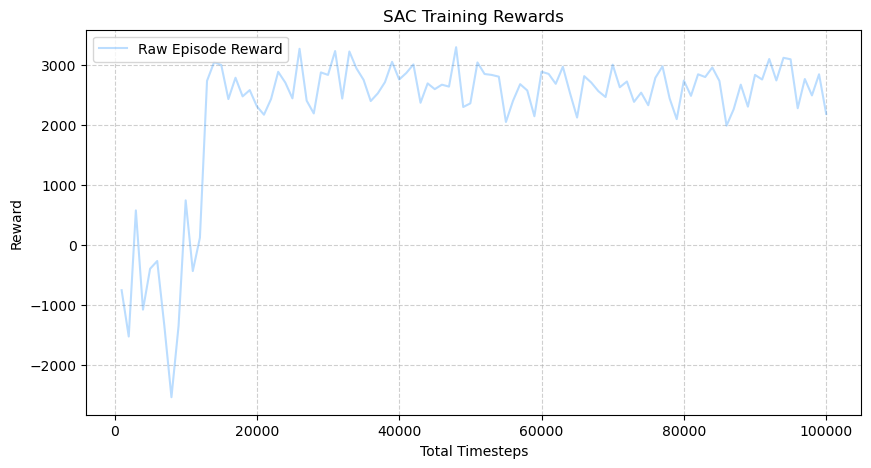

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.results_plotter import load_results, ts2xy

def plot_learning_curve(log_folder, title="SAC Training Rewards"):
    # Load the results from the monitor file
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    
    plt.figure(figsize=(10, 5))
    
    # Plot raw rewards in light blue
    plt.plot(x, y, alpha=0.3, color='dodgerblue', label="Raw Episode Reward")
    
    # # Calculate and plot smoothed rewards
    # if len(y) > 50:
    #     # Convert to numpy array with .values to avoid the ValueError
    #     y_smoothed = pd.Series(y).rolling(window=50).mean().values
    #     plt.plot(x, y_smoothed, color='blue', linewidth=2, label="Rolling Mean (50 ep)")
    
    plt.xlabel('Total Timesteps')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Run the plotting function
plot_learning_curve("./sac_asv_logs/")

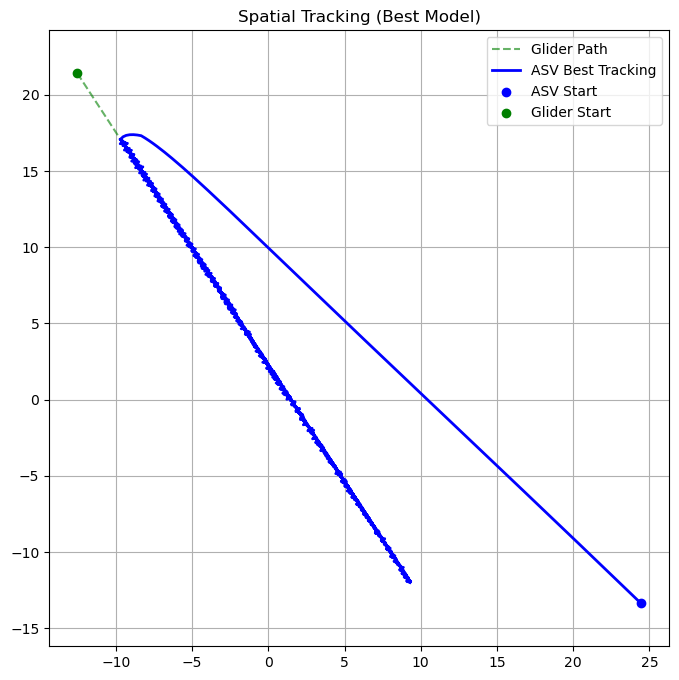

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
import os

# 1. Path to the best model
# Note: Adjust 'logs' to match the folder name you used in the EvalCallback
model_path = "./logs/best_model/best_model.zip"

if not os.path.exists(model_path):
    print(f"Error: Could not find the best model at {model_path}")
else:
    # 2. Load the best model
    model = SAC.load(model_path)
    env = AsvGliderBearingEnv()
    obs, _ = env.reset()

    asv_path, glider_path, rewards = [], [], []
    done = False

    # 3. Run a test episode
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        
        asv_path.append(env.asv_pos.copy())
        glider_path.append(env.glider_pos.copy())
        rewards.append(reward)
        done = terminated or truncated

    asv_path, glider_path = np.array(asv_path), np.array(glider_path)

    # 4. Plot the Map
    plt.figure(figsize=(8, 8))
    plt.plot(glider_path[:, 0], glider_path[:, 1], 'g--', label="Glider Path", alpha=0.6)
    plt.plot(asv_path[:, 0], asv_path[:, 1], 'b-', label="ASV Best Tracking", linewidth=2)
    plt.scatter(asv_path[0,0], asv_path[0,1], c='blue', label="ASV Start")
    plt.scatter(glider_path[0,0], glider_path[0,1], c='green', label="Glider Start")
    plt.title("Spatial Tracking (Best Model)")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# 1. Create a log directory
log_dir = "./sac_asv_logs/"
os.makedirs(log_dir, exist_ok=True)

# 2. Wrap the environment with Monitor
env = AsvGliderBearingEnv()
env = Monitor(env, log_dir)

model = SAC(
    MlpPolicy,
    env,
    verbose=1,
    learning_rate=7e-5, # 3e-4
    gamma=0.99,
    buffer_size=1_000_000,
    learning_starts=10_000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    device="cuda",
)

model.learn(total_timesteps=100_000)
model.save("sac_asv_bearing_dist_1m_new")

env.close()


NameError: name 'MlpPolicy' is not defined

In [15]:
import numpy as np
import matplotlib.pyplot as plt


print("Testing Recurrent PPO policy and recording trajectory...")

obs, info = env.reset()
lstm_state = None
episode_start = np.array([True])  # first step of episode

asv_traj = []
glider_traj = []
rewards = []
times = []

max_steps = 1000  # just for plotting one nice episode

for step in range(max_steps):
    # recurrent predict: pass lstm_state and episode_start
    action, lstm_state = model.predict(
        obs,
        state=lstm_state,
        episode_start=episode_start,
        deterministic=True,
    )

    obs, reward, terminated, truncated, info = env.step(action)

    # record data
    asv_traj.append(env.asv_pos.copy())
    glider_traj.append(env.glider_pos.copy())
    rewards.append(reward)
    times.append(env.t)

    done = terminated or truncated
    episode_start = np.array([done])

    if done:
        print(f"Episode ended at step {step}, t={env.t:.1f}s")
        break

asv_traj = np.array(asv_traj)
glider_traj = np.array(glider_traj)
rewards = np.array(rewards)
times = np.array(times)

# 2D arrays: save as CSV with x,y columns
np.savetxt("asv_traj_sac.csv", asv_traj, delimiter=",", header="x_asv,y_asv", comments="")
np.savetxt("glider_traj_sac.csv", glider_traj, delimiter=",", header="x_glider,y_glider", comments="")

# 1D arrays: save as single-column CSV
np.savetxt("rewards_sac.csv", rewards, delimiter=",", header="reward", comments="")
np.savetxt("times_sac.csv", times, delimiter=",", header="t", comments="")


Testing Recurrent PPO policy and recording trajectory...
Episode ended at step 999, t=100.0s


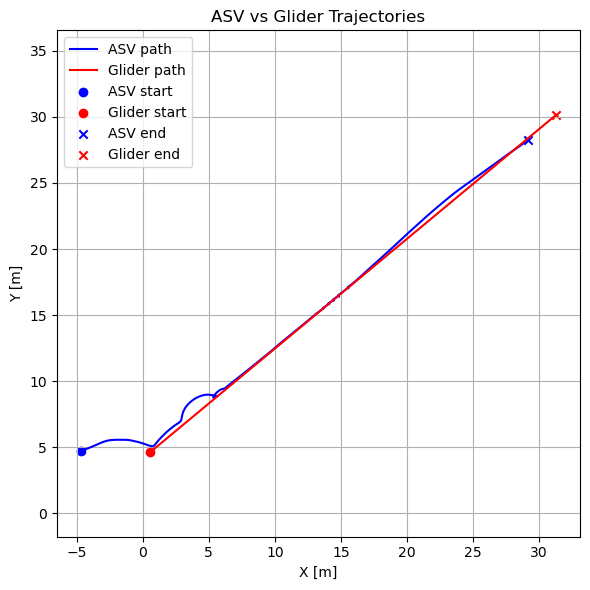

In [16]:
plt.figure(figsize=(6, 6))

# Paths
plt.plot(asv_traj[:, 0], asv_traj[:, 1], label="ASV path", color="blue")
plt.plot(glider_traj[:, 0], glider_traj[:, 1], label="Glider path", color="red")

# Start markers
plt.scatter(asv_traj[0, 0], asv_traj[0, 1], color="blue", marker="o", label="ASV start")
plt.scatter(glider_traj[0, 0], glider_traj[0, 1], color="red", marker="o", label="Glider start")

# End markers
plt.scatter(asv_traj[-1, 0], asv_traj[-1, 1], color="blue", marker="x", label="ASV end")
plt.scatter(glider_traj[-1, 0], glider_traj[-1, 1], color="red", marker="x", label="Glider end")

plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("ASV vs Glider Trajectories")
plt.legend(loc="best")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()


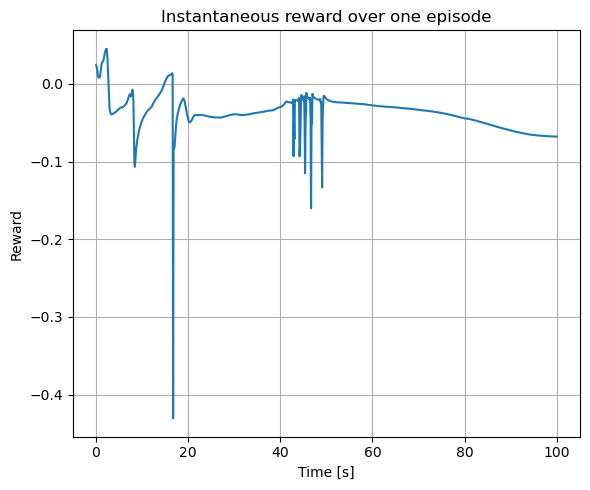

In [17]:
plt.figure(figsize=(6, 5))
plt.plot(times, rewards)
plt.xlabel("Time [s]")
plt.ylabel("Reward")
plt.title("Instantaneous reward over one episode")
plt.grid(True)
plt.tight_layout()
plt.show()


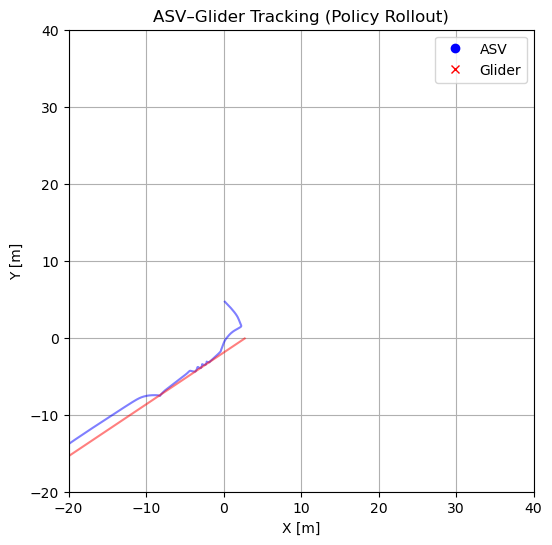

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-20, 40)
ax.set_ylim(-20, 40)
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("ASV–Glider Tracking (Policy Rollout)")
ax.grid(True)

asv_point, = ax.plot([], [], "bo", label="ASV")
glider_point, = ax.plot([], [], "rx", label="Glider")
asv_path, = ax.plot([], [], "b-", alpha=0.5)
glider_path, = ax.plot([], [], "r-", alpha=0.5)
ax.legend()

def init():
    asv_point.set_data([], [])
    glider_point.set_data([], [])
    asv_path.set_data([], [])
    glider_path.set_data([], [])
    return asv_point, glider_point, asv_path, glider_path

def animate(i):
    asv_point.set_data(asv_traj[i, 0], asv_traj[i, 1])
    glider_point.set_data(glider_traj[i, 0], glider_traj[i, 1])
    asv_path.set_data(asv_traj[:i+1, 0], asv_traj[:i+1, 1])
    glider_path.set_data(glider_traj[:i+1, 0], glider_traj[:i+1, 1])
    return asv_point, glider_point, asv_path, glider_path

anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(asv_traj), interval=50, blit=True
)

#plt.show()
# Or save:
anim.save("asv_glider_tracking.mp4", fps=20, extra_args=["-vcodec", "libx264"])
